<a href="https://colab.research.google.com/github/AnantawidyaPrayoga/BookReview/blob/main/Sentiment_Analysis_of_Book_Reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil
#Load the libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
nltk.download('stopwords')
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import spacy
import re,string,unicodedata
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.stem import LancasterStemmer,WordNetLemmatizer
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from textblob import TextBlob
from textblob import Word
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**Sentiment Analysis of IMDB Movie Reviews**

**Problem Statement:**

In this, we have to predict the number of positive and negative reviews based on sentiments by using different classification models.

**Import necessary libraries**

In [10]:
# GitHub CSV file URL
github_csv_url = "https://raw.githubusercontent.com/AnantawidyaPrayoga/BookReview/main/Book%20Reviews%202.csv"

# Load the CSV file into a DataFrame with explicit encoding
data = pd.read_csv(github_csv_url, encoding='ISO-8859-1')

data.head(10)

,Unnamed: 0,Book,Review,Review Date,Sentiment
0,0,To Kill a Mockingbird,/// gentle reminder that this is not the time ...,24-Mar-22,negative
1,1,To Kill a Mockingbird,\n|\n|6.0 stars. I know I am risking a serious...,24-May-11,negative
2,2,To Kill a Mockingbird,\n|\n|Looking for a new book but don't want to...,10-Dec-20,positive
3,3,To Kill a Mockingbird,"To Kill a Mockingbird, Harper Lee|To Kill a Mo...",1-Jul-22,negative
4,4,To Kill a Mockingbird,Why is it when I pick up | To Kill A Mockingbi...,25-Oct-09,negative
5,5,To Kill a Mockingbird,I had a much longer review written for this bo...,17-Dec-20,positive
6,6,To Kill a Mockingbird,NaN,4-Dec-13,NaN
7,7,To Kill a Mockingbird,With endless books and infinitely more to be w...,11-Mar-19,negative
8,8,To Kill a Mockingbird,While the plot was very gripping and well-writ...,18-Apr-12,positive
9,9,To Kill a Mockingbird,"In the course of 5 years, Iâve read this boo...",4-May-15,positive


**Import the training dataset**

In [27]:
# Check for missing values & duplicates
print("Missing values in 'Review' column:", data['Review'].isnull().sum())
print("Duplicates in 'Review' column:", data['Review'].duplicated().sum())
# Drop rows with missing values & duplicates
data = data.dropna(subset=['Review'])
data = data.drop_duplicates(subset=['Review'])

Missing values in 'Review' column: 108
Duplicates in 'Review' column: 144


**Exploratery data analysis**

In [28]:
#Summary of the dataset
data.describe()

,Unnamed: 0,Book,Review,Review Date,Sentiment
count,10860,10860,10860,10859,10860
unique,10860,380,10860,4712,2
top,0,Everything You Need,gentle reminder that this is not the time to ...,4-Dec-13,negative
freq,1,30,1,31,5492


**Sentiment count**

In [29]:
#sentiment count
data['Sentiment'].value_counts()

negative    5492
positive    5368
Name: Sentiment, dtype: int64

We can see that the dataset is balanced.

**Spliting the training dataset**

In [31]:
#split the dataset
#train dataset
train_reviews=data.Review[:7602]
train_sentiments=data.Sentiment[:7602]
#test dataset
test_reviews=data.Review[7602:]
test_sentiments=data.Sentiment[7602:]
print(train_reviews.shape,train_sentiments.shape)
print(test_reviews.shape,test_sentiments.shape)

(7602,) (7602,)
(3258,) (3258,)


**Text normalization**

In [32]:
#Tokenization of text
tokenizer=ToktokTokenizer()
#Setting English stopwords
stopword_list=nltk.corpus.stopwords.words('english')

**Removing html strips and noise text**

In [35]:
#Removing the html strips
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    return text
#Apply function on review column
data['Review']=data['Review'].apply(denoise_text)

<ipython-input-35-881d7219a787>:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


**Removing special characters**

In [36]:
#Define function for removing special characters
def remove_special_characters(text, remove_digits=True):
    pattern=r'[^a-zA-z0-9\s]'
    text=re.sub(pattern,'',text)
    return text
#Apply function on review column
data['Review']=data['Review'].apply(remove_special_characters)

**Text stemming
**

In [37]:
#Stemming the text
def simple_stemmer(text):
    ps=nltk.porter.PorterStemmer()
    text= ' '.join([ps.stem(word) for word in text.split()])
    return text
#Apply function on review column
data['Review']=data['Review'].apply(simple_stemmer)

**Removing stopwords**

In [38]:
#set stopwords to english
stop=set(stopwords.words('english'))
print(stop)

#removing the stopwords
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text
#Apply function on review column
data['Review']=data['Review'].apply(remove_stopwords)

{"wouldn't", 'am', 'at', 'you', "isn't", 'd', 'because', 'to', 'for', 'most', 'about', 'have', 'be', 'yourselves', "you'll", 'she', "wasn't", 'such', 'own', 'some', 'didn', "aren't", 'doesn', "you're", 'her', 'herself', 'as', 'their', 'there', 'just', 'should', 'these', "doesn't", 'or', 'too', 'shan', 'after', 'are', 'will', "should've", 'in', 're', 'your', 'here', 'my', 'weren', 'needn', 'had', "you'd", 'all', 'under', 'which', 'the', 's', "couldn't", 'very', 'above', 'y', 'm', 'an', 'won', 'having', 'who', "didn't", 'while', "hasn't", "you've", 'is', 'ourselves', "she's", 'how', 'yourself', 'down', "haven't", 'against', "that'll", 'over', 'below', 'myself', 'before', 'haven', 'out', 'mustn', "shan't", 'itself', 'through', 'did', 'now', 'does', 'hadn', 'wouldn', 'that', 'being', 'other', "it's", 'with', 'they', 'what', 'during', 'why', 'himself', 'both', 'again', 'if', 'not', 'each', "don't", 'whom', 'same', 'been', 'was', 'don', 'me', 'it', 've', 'ain', 'when', 'he', 'no', 'has', 'th

**Normalized train reviews**

In [40]:
#normalized train reviews
norm_train_reviews=data.Review[:7602]
norm_train_reviews[0]
#convert dataframe to string
#norm_train_string=norm_train_reviews.to_string()
#Spelling correction using Textblob
#norm_train_spelling=TextBlob(norm_train_string)
#norm_train_spelling.correct()
#Tokenization using Textblob
#norm_train_words=norm_train_spelling.words
#norm_train_words

'gentl remind thi time read thi book thi first reread 2017 dont regret one bit first read thi book three year ago realli like sadli didnt write thought elabor way back day know sure didnt read critic upon reread thi book honestli dont good thing say awar critic critiqu book percept thi day held one true book race relat unit state americaand realli infiru thi book wa written white woman white perspect white charact white audienc thi book pat back white middl class thi book give comfort white middl class comfort especi back 1960 didnt need allow bold didnt deserv harper lee focu pure white white charact thi book subject take action hand suffer make sacrific black charact thi book object littl agenc thing happen harmless defenseless wait white knight hero atticu finch save thi book disgrac face black liber movement exist back day solidar within black commun black peopl stood themselv fought right onli due voic protest sitin march demonstr confer wa racial segreg made unconstitut unit stat

**Normalized test reviews**

In [43]:
#Normalized test reviews
norm_test_reviews=data.Review[7602:]
norm_test_reviews[8000]
##convert dataframe to string
#norm_test_string=norm_test_reviews.to_string()
#spelling correction using Textblob
#norm_test_spelling=TextBlob(norm_test_string)
#print(norm_test_spelling.correct())
#Tokenization using Textblob
#norm_test_words=norm_test_spelling.words
#norm_test_words

'note marginfootprint sand timehello dont know bought book onlin dont know name dont even know whether dead aliv made notat margin notic straight away pencil later look pen although might made someon els start note similar thing make similar comment start make fewer comment becaus wa content either start think like walk footstep im reader like reader like reader like pleas whoever dont think mani us around let know get thi messag meantim ill tri write review hope ok one hope like note marginfriend foefo rais fascin metafict idea text econom 157 page intellectu aesthet stimulatingit postmodern reconstruct robinson cruso ask question empir coloni slaveri dominion histori fiction narr especi ownership stori whose stori perspect tell stori stori resultsplant quotat markscoetze tell hi tale four partsth first wholli contain quotat mark purport perspect susan barton incident charact subsequ daniel defo novel roxana foe end island cruso sic friday whose tongu ha cut slaversth second larg epis

**Bags of words model **

It is used to convert text documents to numerical vectors or bag of words.

In [44]:
#Count vectorizer for bag of words
cv=CountVectorizer(min_df=0,max_df=1,binary=False,ngram_range=(1,3))
#transformed train reviews
cv_train_reviews=cv.fit_transform(norm_train_reviews)
#transformed test reviews
cv_test_reviews=cv.transform(norm_test_reviews)

print('BOW_cv_train:',cv_train_reviews.shape)
print('BOW_cv_test:',cv_test_reviews.shape)
#vocab=cv.get_feature_names()-toget feature names

BOW_cv_train: (7602, 2217598)
BOW_cv_test: (3258, 2217598)


**Term Frequency-Inverse Document Frequency model (TFIDF)**

It is used to convert text documents to  matrix of  tfidf features.

In [45]:
#Tfidf vectorizer
tv=TfidfVectorizer(min_df=0,max_df=1,use_idf=True,ngram_range=(1,3))
#transformed train reviews
tv_train_reviews=tv.fit_transform(norm_train_reviews)
#transformed test reviews
tv_test_reviews=tv.transform(norm_test_reviews)
print('Tfidf_train:',tv_train_reviews.shape)
print('Tfidf_test:',tv_test_reviews.shape)

Tfidf_train: (7602, 2217598)
Tfidf_test: (3258, 2217598)


**Labeling the sentiment text**

In [46]:
#labeling the sentient data
lb=LabelBinarizer()
#transformed sentiment data
sentiment_data=lb.fit_transform(data['Sentiment'])
print(sentiment_data.shape)

(10860, 1)


**Split the sentiment tdata**

In [47]:
#Spliting the sentiment data
train_sentiments=sentiment_data[:7602]
test_sentiments=sentiment_data[7602:]
print(train_sentiments)
print(test_sentiments)

[[0]
 [0]
 [1]
 ...
 [1]
 [1]
 [0]]
[[1]
 [1]
 [0]
 ...
 [1]
 [1]
 [1]]


**Modelling the dataset**

Let us build logistic regression model for both bag of words and tfidf features

In [48]:
#training the model
lr=LogisticRegression(penalty='l2',max_iter=500,C=1,random_state=42)
#Fitting the model for Bag of words
lr_bow=lr.fit(cv_train_reviews,train_sentiments)
print(lr_bow)
#Fitting the model for tfidf features
lr_tfidf=lr.fit(tv_train_reviews,train_sentiments)
print(lr_tfidf)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1, max_iter=500, random_state=42)


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1, max_iter=500, random_state=42)


**Logistic regression model performane on test dataset**

In [49]:
#Predicting the model for bag of words
lr_bow_predict=lr.predict(cv_test_reviews)
print(lr_bow_predict)
##Predicting the model for tfidf features
lr_tfidf_predict=lr.predict(tv_test_reviews)
print(lr_tfidf_predict)

[0 1 0 ... 0 0 1]
[0 0 0 ... 0 0 0]


**Accuracy of the model**

In [50]:
#Accuracy score for bag of words
lr_bow_score=accuracy_score(test_sentiments,lr_bow_predict)
print("lr_bow_score :",lr_bow_score)
#Accuracy score for tfidf features
lr_tfidf_score=accuracy_score(test_sentiments,lr_tfidf_predict)
print("lr_tfidf_score :",lr_tfidf_score)

lr_bow_score : 0.4910988336402701
lr_tfidf_score : 0.4978514426028238


**Print the classification report**

In [52]:
#Classification report for bag of words
lr_bow_report=classification_report(test_sentiments,lr_bow_predict,target_names=['positive','negative'])
print(lr_bow_report)

#Classification report for tfidf features
lr_tfidf_report=classification_report(test_sentiments,lr_tfidf_predict,target_names=['positive','negative'])
print(lr_tfidf_report)

              precision    recall  f1-score   support

    positive       0.49      0.66      0.57      1627
    negative       0.49      0.32      0.39      1631

    accuracy                           0.49      3258
   macro avg       0.49      0.49      0.48      3258
weighted avg       0.49      0.49      0.48      3258

              precision    recall  f1-score   support

    positive       0.50      0.89      0.64      1627
    negative       0.49      0.10      0.17      1631

    accuracy                           0.50      3258
   macro avg       0.50      0.50      0.41      3258
weighted avg       0.50      0.50      0.40      3258



**Confusion matrix**

In [53]:
#confusion matrix for bag of words
cm_bow=confusion_matrix(test_sentiments,lr_bow_predict,labels=[1,0])
print(cm_bow)
#confusion matrix for tfidf features
cm_tfidf=confusion_matrix(test_sentiments,lr_tfidf_predict,labels=[1,0])
print(cm_tfidf)

[[ 520 1111]
 [ 547 1080]]
[[ 168 1463]
 [ 173 1454]]


**Stochastic gradient descent or Linear support vector machines for bag of words and tfidf features**

In [54]:
#training the linear svm
svm=SGDClassifier(loss='hinge',max_iter=500,random_state=42)
#fitting the svm for bag of words
svm_bow=svm.fit(cv_train_reviews,train_sentiments)
print(svm_bow)
#fitting the svm for tfidf features
svm_tfidf=svm.fit(tv_train_reviews,train_sentiments)
print(svm_tfidf)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SGDClassifier(max_iter=500, random_state=42)


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SGDClassifier(max_iter=500, random_state=42)


**Model performance on test data**

In [55]:
#Predicting the model for bag of words
svm_bow_predict=svm.predict(cv_test_reviews)
print(svm_bow_predict)
#Predicting the model for tfidf features
svm_tfidf_predict=svm.predict(tv_test_reviews)
print(svm_tfidf_predict)

[0 1 0 ... 1 0 1]
[0 1 0 ... 0 0 1]


**Accuracy of the model**

In [56]:
#Accuracy score for bag of words
svm_bow_score=accuracy_score(test_sentiments,svm_bow_predict)
print("svm_bow_score :",svm_bow_score)
#Accuracy score for tfidf features
svm_tfidf_score=accuracy_score(test_sentiments,svm_tfidf_predict)
print("svm_tfidf_score :",svm_tfidf_score)

svm_bow_score : 0.4871086556169429
svm_tfidf_score : 0.48987108655616945


**Print the classification report**

In [57]:
#Classification report for bag of words
svm_bow_report=classification_report(test_sentiments,svm_bow_predict,target_names=['Positive','Negative'])
print(svm_bow_report)
#Classification report for tfidf features
svm_tfidf_report=classification_report(test_sentiments,svm_tfidf_predict,target_names=['Positive','Negative'])
print(svm_tfidf_report)

              precision    recall  f1-score   support

    Positive       0.49      0.56      0.52      1627
    Negative       0.49      0.41      0.44      1631

    accuracy                           0.49      3258
   macro avg       0.49      0.49      0.48      3258
weighted avg       0.49      0.49      0.48      3258

              precision    recall  f1-score   support

    Positive       0.49      0.62      0.55      1627
    Negative       0.49      0.36      0.41      1631

    accuracy                           0.49      3258
   macro avg       0.49      0.49      0.48      3258
weighted avg       0.49      0.49      0.48      3258



**Plot the confusion matrix**

In [58]:
#confusion matrix for bag of words
cm_bow=confusion_matrix(test_sentiments,svm_bow_predict,labels=[1,0])
print(cm_bow)
#confusion matrix for tfidf features
cm_tfidf=confusion_matrix(test_sentiments,svm_tfidf_predict,labels=[1,0])
print(cm_tfidf)

[[669 962]
 [709 918]]
[[ 580 1051]
 [ 611 1016]]


**Multinomial Naive Bayes for bag of words and tfidf features**

In [59]:
#training the model
mnb=MultinomialNB()
#fitting the svm for bag of words
mnb_bow=mnb.fit(cv_train_reviews,train_sentiments)
print(mnb_bow)
#fitting the svm for tfidf features
mnb_tfidf=mnb.fit(tv_train_reviews,train_sentiments)
print(mnb_tfidf)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MultinomialNB()
MultinomialNB()


**Model performance on test data**

In [60]:
#Predicting the model for bag of words
mnb_bow_predict=mnb.predict(cv_test_reviews)
print(mnb_bow_predict)
#Predicting the model for tfidf features
mnb_tfidf_predict=mnb.predict(tv_test_reviews)
print(mnb_tfidf_predict)

[0 1 0 ... 0 0 1]
[0 1 0 ... 0 0 0]


**Accuracy of the model**

In [61]:
#Accuracy score for bag of words
mnb_bow_score=accuracy_score(test_sentiments,mnb_bow_predict)
print("mnb_bow_score :",mnb_bow_score)
#Accuracy score for tfidf features
mnb_tfidf_score=accuracy_score(test_sentiments,mnb_tfidf_predict)
print("mnb_tfidf_score :",mnb_tfidf_score)

mnb_bow_score : 0.4858809085328422
mnb_tfidf_score : 0.5030693677102517


**Print the classification report**

In [62]:
#Classification report for bag of words
mnb_bow_report=classification_report(test_sentiments,mnb_bow_predict,target_names=['Positive','Negative'])
print(mnb_bow_report)
#Classification report for tfidf features
mnb_tfidf_report=classification_report(test_sentiments,mnb_tfidf_predict,target_names=['Positive','Negative'])
print(mnb_tfidf_report)

              precision    recall  f1-score   support

    Positive       0.49      0.59      0.53      1627
    Negative       0.48      0.38      0.43      1631

    accuracy                           0.49      3258
   macro avg       0.49      0.49      0.48      3258
weighted avg       0.49      0.49      0.48      3258

              precision    recall  f1-score   support

    Positive       0.50      0.73      0.60      1627
    Negative       0.51      0.27      0.36      1631

    accuracy                           0.50      3258
   macro avg       0.50      0.50      0.48      3258
weighted avg       0.50      0.50      0.48      3258



**Plot the confusion matrix**

In [63]:
#confusion matrix for bag of words
cm_bow=confusion_matrix(test_sentiments,mnb_bow_predict,labels=[1,0])
print(cm_bow)
#confusion matrix for tfidf features
cm_tfidf=confusion_matrix(test_sentiments,mnb_tfidf_predict,labels=[1,0])
print(cm_tfidf)

[[ 626 1005]
 [ 670  957]]
[[ 448 1183]
 [ 436 1191]]


**Let us see positive and negative words by using WordCloud.**

**Word cloud for positive review words**

<function matplotlib.pyplot.show(close=None, block=None)>

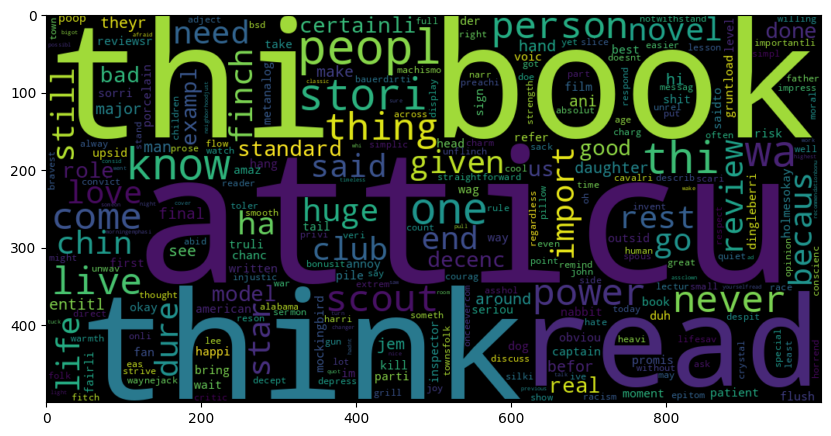

In [64]:
#word cloud for positive review words
plt.figure(figsize=(10,10))
positive_text=norm_train_reviews[1]
WC=WordCloud(width=1000,height=500,max_words=500,min_font_size=5)
positive_words=WC.generate(positive_text)
plt.imshow(positive_words,interpolation='bilinear')
plt.show

**Word cloud for negative review words**

<function matplotlib.pyplot.show(close=None, block=None)>

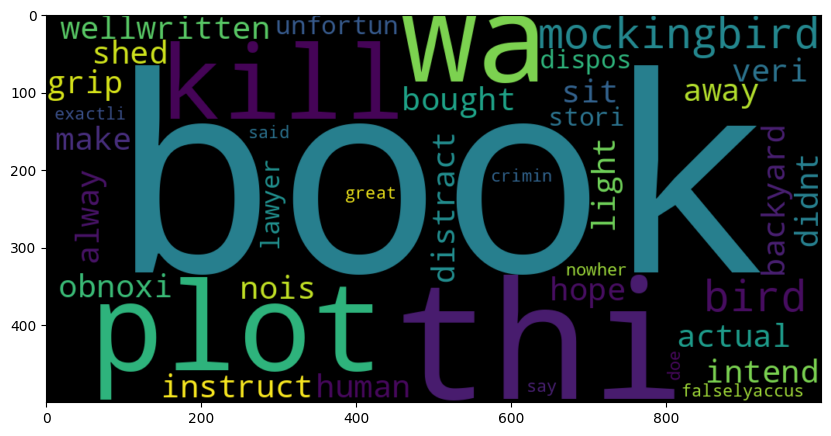

In [65]:
#Word cloud for negative review words
plt.figure(figsize=(10,10))
negative_text=norm_train_reviews[8]
WC=WordCloud(width=1000,height=500,max_words=500,min_font_size=5)
negative_words=WC.generate(negative_text)
plt.imshow(negative_words,interpolation='bilinear')
plt.show

**Conclusion:**
* We can observed that both logistic regression and multinomial naive bayes model performing well compared to linear support vector  machines.
* Still we can improve the accuracy of the models by preprocessing data and by using lexicon models like Textblob.